<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/6_%ED%86%B5%EA%B3%84%EC%A0%81_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [1]:
! pip install wquantiles 
! pip install dmba

import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

# import warnings
# warnings.filterwarnings("ignore")

     |████████████████████████████████| 11.8 MB 4.4 MB/s 
no display found. Using non-interactive Agg backend
Cloning into 'practical-statistics-for-data-scientists'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 384 (delta 87), reused 100 (delta 29), pack-reused 207
Receiving objects: 100% (384/384), 84.82 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [2]:
LOAN200_CSV = DATA / 'loan200.csv'
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 1. k-최근접 이웃(KNN)

- 아래와 같은 순서를 통해 분류 혹은 예측한다.

  1. 특징들이 가장 유사한(즉, 예측변수들이 유사한) k개의 레코드를 찾는다.
  2. 분류: 이 유사한 레코드들 중에 다수가 속한 클래스가 무엇인지 찾은 후에 새로운 레코드를 그 클래스에 할당한다.
  3. 예측(KNN 회귀(KNN regression)라고도 함) : 유사한 레코드들의 평균을 찾아서 새로운 레코드에 대한 예측값으로 사용한다.


- k에 대한 설정에 따라 예측 결과가 달라진다.



### 1. 예제
- 렌딩클럽(투자자들이 모은 돈을 개인에게 대출해주는 P2P 방식의 대출 업체)의 대출 정보 중 일부

In [3]:
loan200 = pd.read_csv(LOAN200_CSV)

display(loan200)

# 사용하는 핏쳐는 2개
# payment_inc_ratio : 대출 상환 비율
# dti : 소득에 대한 부채 비율
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20) # 20
knn.fit(X, y)
knn.predict(newloan)
print('예측 결과 비율 : ', knn.predict_proba(newloan))
print('예측 결과 클래스 : ', knn.predict(newloan))

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81
...,...,...,...
196,default,11.66300,26.09
197,default,2.97641,16.41
198,default,1.96846,19.98
199,paid off,9.64200,20.17


예측 결과 비율 :  [[0.45 0.55]]
예측 결과 클래스 :  ['paid off']


두변수를 이용한 KNN의 대출 연체 예측


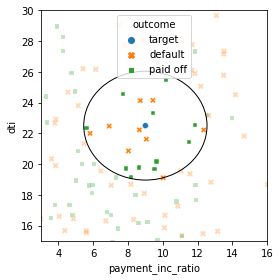

In [4]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

print('두변수를 이용한 KNN의 대출 연체 예측')
plt.tight_layout()
plt.show()

- 파란색 원이 새로운 대출에 대한 예측 결과이다.
- 원은 가장 가까운 20개의 점들에 대한 경계선을 보여준다.
- 가까운 9개에서 연체 발생, 11번째에서 상환이 이뤄졌으며 그럼으로 인해 예측결과는 상환이 된다.

### 2. 거리지표

- 유사성(=근접성)은 거리 지표를 통해 결정 된다. 
- 두 데이터가 얼마나 멀리 떨어져있는지 측정하는 함수이다.
- 유클리드거리 : 두 벡터사이에 가장 많이 사용되는 지표로, 서로의 차이에 대한 제곱합을 구한 뒤 그 값의 제곱근을 취한다.

- 맨해튼 거리 :  맨하탄 거리라는 이름도 도시의 골목길(블록)을 걸을 때의 모습과 유사

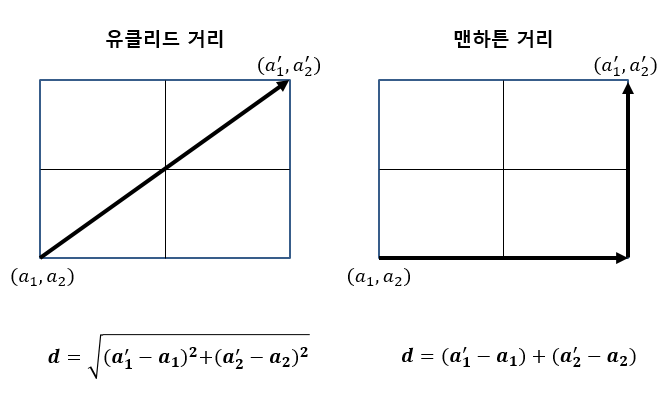

### 3. 원-핫 인코더

- 문자열 변수의 경우 통계모델에서 이진 가변수 집합으로 변환이 필요하다.
- 1과 0으로 이뤄진 벡터 형태로 변환하여 머신러닝 알고리즘에 사용

In [5]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data_home_ownership = loan_data['home_ownership']
print('주거 소유 상태 정보를 가변수로 표현')
pd.get_dummies(loan_data_home_ownership)

주거 소유 상태 정보를 가변수로 표현


,MORTGAGE,OTHER,OWN,RENT
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
45337,0,0,0,1
45338,1,0,0,0
45339,1,0,0,0
45340,1,0,0,0


### 4. 표준화(정규화, z 점수)

- 표준화(=정규화) : 모든 변수에서 평균을 빼고 표준편차로 나누는 과정을 통해 변수들을 모두 비슷한 스케일에 놓는 것. 실제 측정된 값의 스케일 때문에 모델에 심한 영향을 주는 것을 막을 수 있다.

 ### $z = \frac{x- \bar{x}}{s}$
 - s = 표준편차, $\bar{x}$ = 평균
 
- 결과를 일반적으로 z점수라고 부르며, 이는 평균으로부터 표준편차만큼 얼마나 떨어져 있는지를 의미한다.

In [6]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])

loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


# 핏쳐 4개 사용
# revol_bal : 달러로 신청할 수 있는 총 회전 신용
# revol_util : 이미 사용 중인 신용비율
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print('1. 예측할 새로운 레코드 : \n', newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print('\n2. 가장 가까운 5개의 레코드')
print(X.iloc[nbrs[1][0], :])

1. 예측할 새로운 레코드 : 
    payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4

2. 가장 가까운 5개의 레코드
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


- revol_bal 값은 새 데이터 값과 아주 비슷하지만, 다른 예측 변수들은 넓게 퍼져있는 것을 볼 수 있다.
- 이웃들을 결정할 때 다른 변수들의 역할이 별로 중요하지 않았다고 볼 수 있다.

In [7]:
print('표준화 적용 KNN모델')

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

# 데이터 표준화 적용한 후 비교
scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

표준화 적용 KNN모델
       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


- 새롭게 얻은 최근접 이웃들은 모든 변수에서 훨씬 더 유사한 것을 볼 수 있다.

### 5. k 선택하기

- k가 너무 작을 때 : 데이터의 노이즈 성분까지 고려하는 오버피팅 문제
- k가 너무 클 때 : 결정함수가 너무 과하게 평탄화 되어 예측 기능을 잃게 됨

- 최적의 k 값을 찾는 방법 : validation set의 정확도를 가지고 k값을 결정

- 노이즈가 적은 데이터의 경우 k값이 작을 수록 잘 동작, 노이즈가 많은 데이터의 경우 k가 클 수록 잘 동작 (보통 k=1~20 사이)

### 6. KNN을 통한 피처 엔지니어링

- KNN을 통해 지역적 정보를 새로운 특징(핏쳐)로 추가하는 '피처 엔지니어링'을 할 수 있다.

- 예시 : 킹카운티 주택 데이터 



count    45342.000000
mean         0.501098
std          0.128736
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


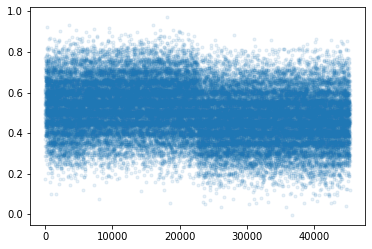

In [8]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

- 신용 기록을 기초로 대출자가 대출을 갚지 못할 것으로 예상되는 핏쳐 'borrower_score'를 생성 함

# 2. 트리 모델

- 의사결정트리 라고도 부르며, 분류하거나 예측하기 위한 일련의 규칙들을 생성한다.
- 데이터를 하위 영역으로 연속적으로 분할하는 것과 관련이 있다.
- 각 단계마다, 트리 알고리즘은 결과의 불순도를 최소화하는 쪽으로 영역 분할을 진행한다.
- 오버피팅이 발생하는 경우 트리에 가지치기를 수행해야 한다.

- 클래스 순도를 측정하기 위해 지니 불순도와 엔트로피를 사용한다.
### 지니불순도 = $I(A)=p(1-p)$
### 엔트로피 = $I(A)=-plog_{2}(p)-(1-p)log_{2}(1-p)$
  - $p$ = 오분류된 레코드의 비율

- 트리 모델의 장점
 1. 데이터 탐색을 위한 시각화가 가능하다
 2. 일종의 규칙들의 집합으로 비전문가들과 대화하는데에 아주  효과 적일 수 있다.

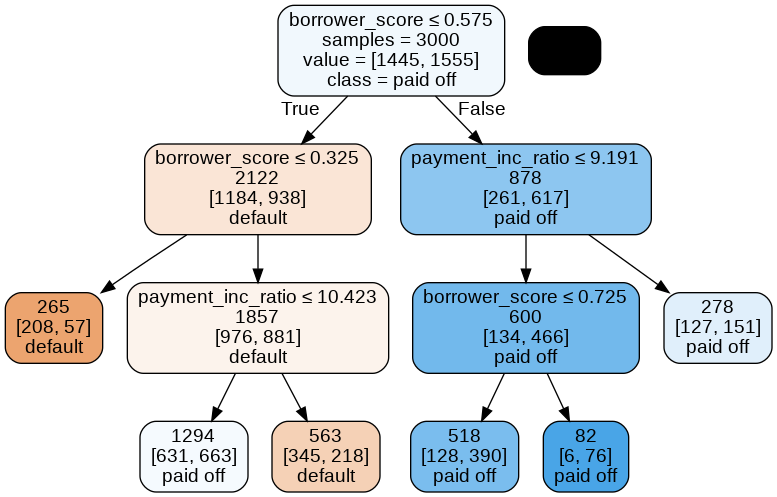

In [9]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [10]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


- 루트노드에서 시작하여 잎 노드에 도달할 때까지 노드가 참이면 왼쪽 거짓이면 오른쪽으로 움직인다.

- 만약 borrower_score = 0.6, payment_inc_ratio=8.0인 대출 정보를 얻었다면, 결국 대출을 상환할 것으로 예측할 수 있다.

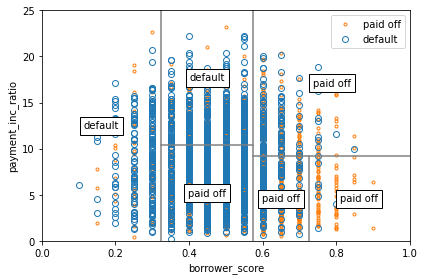

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

- 규칙들을 영역으로 분할 한 것으로 예측변수 값을 기준으로 데이터를 반복 분할해 나간다.

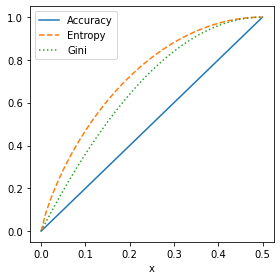

In [12]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

- 정확도와 엔트로피, 지니 불순도를 측정하였다.
- 정확도가 높은 부분에서 지니불순도와 엔트로피 측정값이 비슷하게 높아지는 것을 볼 수 있다.
- 오버피팅을 방지하기 위해 가지치기를 할때는 하이퍼파라미터 서치를 통해 할 수 있다.

# 3. 배깅과 랜덤 포레스트

- 앙상블(bagging) : 여러 모델의 집합을 이용하여 하나의 예측을 이끌어 내는 방식
  1. 주어진 데이터에 대해 예측 모델을 만들고 예측 결과를 기록한다.
  2. 같은 데이터에 대해 여러 모델을 만들고 결과를 기록한다.
  3. 각 레코드에 대해 예측된 결과들의 평균(또는 가중평균, 다수결 투표)을 구한다.

- 배깅(bagging) : 데이터를 부트스트래핑해서 여러 모델을 만드는 일반적인 방법
  1. 만들 모델의 개수 M과 모델을 만드는 데 사용할 레코드의 개수 n(n < N)의 값을  초기화한다. 반복 변수 m = 1로 놓는다.
  2. 훈련 데이터로부터 복원추출 방법으로 n개의 부분 데이터 Ym과 Xm을 부트스트랩 재표본 추출한다.
  3. 의사 결정 규칙 ${\hat{f}}_{m}(X)$를 얻기 위해, Ym과 Xm을 이용해 모델을 학습한다.
  4. m = m + 1로 모델 개수를 늘린다. m <= M 이면 다시 1단계로 간다.

 $ \hat{f} = \frac{1}{M}(\hat{f_{1}}(X)+\hat{f_{2}}(X)+\cdots \hat{f}_{M}(X))$
 
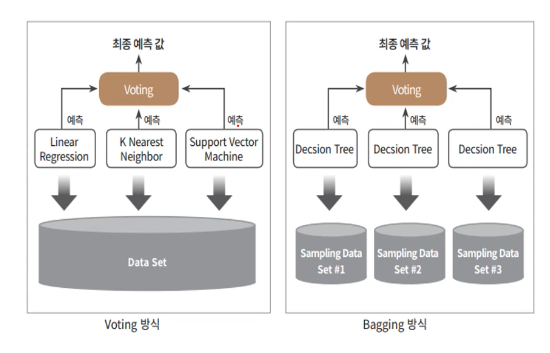

- 랜덤포레스트(Random forest) : 여러개의 decision tree를 형성하고 새로운 데이터 포인트를 각 트리에 동시에 통과시키며, 각 트리가 분류한 결과에서 투표를 실시하여 가장 많이 득표한 결과를 최종 분류 결과로 선택 

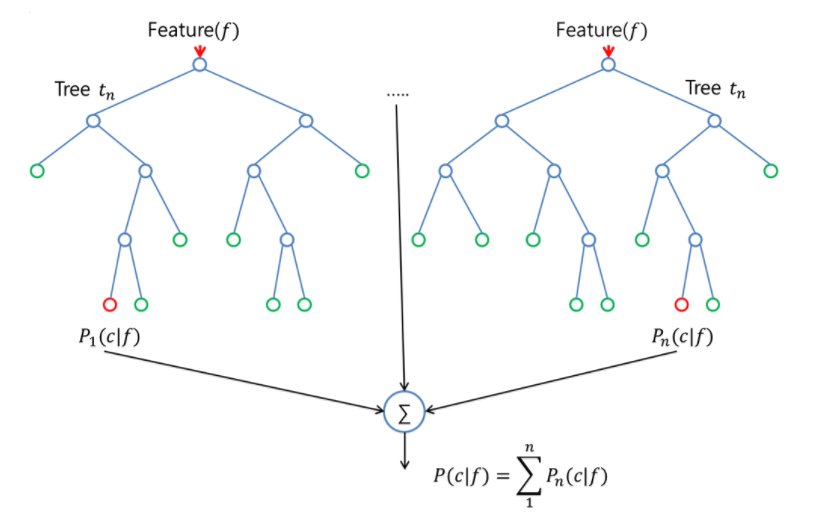

- 주머니 외부(OOB) 추정 에러 : 트리 모델을 만들 때 사용했던 학습 데이터에 속하지 않는 데이터를 사용해 구한, 학습된 모델의 오차율

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


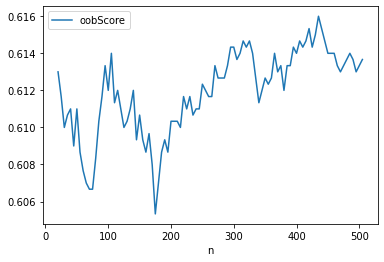

In [13]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

n_estimator = list(range(20, 510, 5))

oobScores = []

for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

- 오차율이 200언저리에서 제일 낮은 것을 알 수 있다.

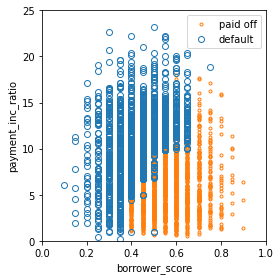

In [14]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

- 신용점수가 높은 사람 중에도 대출을 다 갚지 못할 것이라는 예측결과가 나오는데 이것은 오버피팅으로 볼 수 있다.

### 변수 중요도 

- 랜덤포레스트는 예측변수 중에 존재하는 상관관계 항들에 대응되는 복잡한 관계들을 자동으로 결정하는 능력이 있다.

In [15]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [16]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0667, 'borrower_score'), (0.0379, 'grade'), (0.0281, 'term_60 months'), (0.0106, 'annual_inc'), (0.0088, 'payment_inc_ratio'), (0.0031, 'dti'), (0.0024, 'revol_bal'), (0.0021, 'open_acc'), (0.0017, 'purpose_small_business'), (0.0009, 'emp_length'), (0.0006, 'purpose__small_business'), (0.0004, 'pub_rec_zero'), (0.0004, 'emp_len__ > 1 Year'), (0.0001, 'purpose_other'), (0.0001, 'purpose_moving'), (0.0001, 'purpose_house'), (0.0001, 'purpose__home_improvement'), (-0.0, 'purpose_vacation'), (-0.0, 'purpose_medical'), (-0.0001, 'purpose_home_improvement'), (-0.0001, 'purpose__medical'), (-0.0002, 'purpose_wedding'), (-0.0003, 'purpose__other'), (-0.0005, 'purpose__major_purchase'), (-0.0006, 'purpose_credit_card'), (-0.0006, 'home__OWN'), (-0.0008, 'purpose_major_purchase'), (-0.0013, 'home__RENT'), (-0.0013, 'delinq_2yrs_zero'), (-0.0016, 'revol_util'), (-0.0016, 'purpose__debt_consolidation'), (-0.0025, 'purpose_debt_consolidation'), (-0.0031, 'loan_am

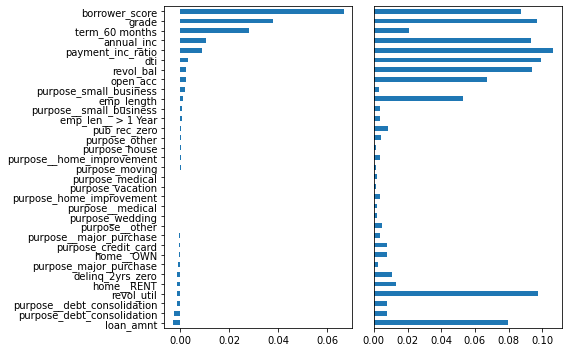

In [17]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# 4. 부스팅

- 부스팅은 모델들을 앙상블 형태로 만드는 일반적인 기법이다. 배깅과 비슷한 시기에 개발 되었다.

- 부스팅(boosting): 연속된 라운드마다 잔차가 큰 레코드들에 가중치를 높여 일련의 모델들을 생성하는 일반적인 기법
  - ex) 에이다부스트, 그레이디언트 부스팅, 확률적 그레이디언트 부스팅
  - 에이다부스트(AdaBoost): 잔차에 따라 데이터의 가중치를 조절하는 부스팅의 초기 버전
  - 그레디언트 부스팅(gradient boosting): 비용함수(cost function)를 최소화하는 방향으로 부스팅을 활용하는 좀 더 일반적인 형태
  - 확률적 그레디언트 부스팅(stochastic gradient boosting): 각 라운드마다 레코드와 열을 재표본추출하는 것을 포함하는 부스팅의 가장 일반적인 형태
- XG부스트(XGBoost): 대중적으로 가장 많이 사용되는 확률적 그레이디언트 부스팅 오픈소스 소프트웨어.
- 정규화(regularization): 비용함수에 모델의 파라미터 개수에 해당하는 벌점 항을 추가해 오버피팅을 피하는 방법

- 예시) xgboost로 대출데이터에 대한 예측 결과 (2가지 핏쳐만 사용)



   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.560805
1            0.40            5.43165    default      0.442436
2            0.70            9.23003   paid off      0.684751
3            0.40            2.33482   paid off      0.538130
4            0.45           12.10320    default      0.369834
xgboost 모델 실행 결과


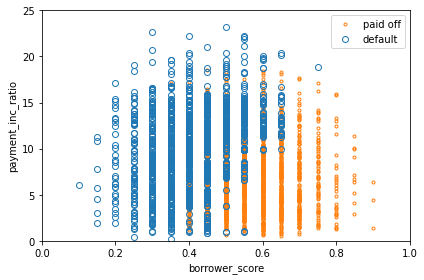

In [21]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')

xgb_df = X.copy()
xgb.fit(X, y)
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

print('xgboost 모델 실행 결과')
plt.tight_layout()
plt.show()

- 랜덤포레스트를 이용했을 때와 예측결과가 비슷한 것을 볼 수 있다.

In [22]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')

xgb_penalty.fit(train_X, train_y)

pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.12523343330881104
default:  0.3541
penalty:  0.332


- train 데이터의 오차율은 13.3% 이지만, 테스트 데이터의 오차율은 35.3%로 오버피팅 된 것을 알 수 있다.

- 이를 방지하기 위해 정규화 방법(alpha, lambda 값 조절)을 쓸 수 있다.

   iterations  default train  penalty train  default test  penalty test
0           1       0.340049       0.336116        0.3513        0.3522
1           2       0.330768       0.334588        0.3430        0.3464
2           3       0.328136       0.338634        0.3405        0.3565
3           4       0.324232       0.338973        0.3385        0.3547
4           5       0.319846       0.335465        0.3399        0.3479


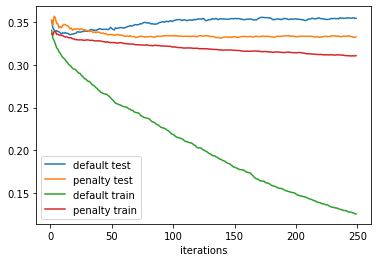

In [23]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

- 기존의 xgboost와 정규화 적용한 xgboost의 오차율 비교
- penalty(정규화)를 시킨 모델이 경우 그렇지 않은 모델보다 좋은 에러율을 보이고 있다.

# 5. 하이퍼파라미터와 교차타당성검사

- 하이퍼파라미터 : 특정 파라미터의 선정을 통해 모델의 성능을 개선할 수 있다.

- 교차타당성검사 : 데이터를 서로 다른 그룹=폴드로 랜덤하게 나눈 뒤, 각 폴드마다 해당 폴드를 제외한 나머지 데이터를 가지고 모델을 학습한 후 폴드에 속한 데이터를 이용하여 모델을 평가한다.

In [24]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        use_label_encoder=False, eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3285536192891131}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3357579038956991}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3412107669616872}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.34125713077604675}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.368663771690878}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3721218091860381}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3543114276588054}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.38634589595306884}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.38205967825460185}
   eta  max_depth  avg_error
0  0.1          3   0.328554
1  0.1          6   0.335758
2  0.1          9   0.341211
3  0.5          3   0.341257
4  0.5          6   0.368664
5  0.5          9   0.372122
6  0.9          3   0.354311
7  0.9          6   0.386346
8  0.9          9   0.382060


In [25]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.855362  33.575790  34.121077
0.5        34.125713  36.866377  37.212181
0.9        35.431143  38.634590  38.205968


- 결과 정리를 통해 eta/learning_rate 값이 적으면서 깊이가 얕은 트리를 사용하는 것이 좋은 성능을 보인다는 것을 알 수 있다.